In [123]:
from netgen.geom2d import unit_square
from ngsolve import *
import pandas as pd
from ngsolve import grad as ngsolvegrad
from ngsolve.comp import ProxyFunction
from ngsolve.webgui import Draw

#### Configuration Setup

In [124]:
beta = (2,0.001)
eps = 0.01

p = lambda x: x + (exp(beta[0]*(x-1)/eps)-exp(-beta[0]/eps))/(exp(-beta[0]/eps)-1)
q = lambda y: y + (exp(beta[1]*(y-1)/eps)-exp(-beta[1]/eps))/(exp(-beta[1]/eps)-1)

exact = p(x) * q(y)
coeff =  beta[1] * p(x) +  beta[0] * q(y)


new_config = {
    'order': [1, 2, 3, 4],
    'beta': (2,0.001),
    'mesh_size': [1.0, 0.5, 0.25, 0.1250, 0.0625, 0.0313],
    'epsilon': 0.01,
    'exact': exact,
    'coeff': coeff,
    'alpha': 20, 
    'enrich_functions':[p(x), q(y)],
    'enrich_domain_ind':[lambda x,y,h: x > 1 - h/2, lambda x,y,h: y > 1 - h/2]
}


columns = ['Order', 'Mesh Size', 'Error']
error_table = pd.DataFrame(columns=columns)

#### Enrichment Proxy Functions for the DG method

In [125]:
class EnrichmentProxy(CoefficientFunction):
    """
    Provide wrappers for grad/Other and multiplication of enrichment lists for the DG Method.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]

    def __call__(self):
        return self.func[0] + sum([self.func[i]*self.enr_list[i-1] for i in range(1,len(self.enr_list)+1)])

    def __mul__(self, other):
        if type(other) == EnrichmentProxy:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self,other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)
    
    #gradient of newly enriched approximation spaces
    def grad(self):
        mygrad = ngsolvegrad(self.func[0])
        for i in range(1,len(self.enr_list)):
            mygrad += self.func[i] * self.grad_list[i-1]
            mygrad += ngsolvegrad(self.func[i])*self.enr_list[i-1]
        return mygrad 
    
    
    '''define proxy functions for Other'''
    def Other(self):
        return EnrichmentProxy([f.Other() for f in self.func],self.enr_list)

#### Enrichment Proxy Functions for the HDG method

In [126]:
class EnrichmentProxy_VOL(CoefficientFunction):
    """
    Provide wrappers for grad/Other and multiplication of enrichment lists for the HDG method.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]
    
    def __call__(self):
        return self.func[0] + sum([self.func[2 + 2* i] * self.enr_list[i] for i in range(0,len(self.enr_list))])

    def __mul__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self, other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy_VOL:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)
    
    
    '''gradient of newly enriched approximation spaces'''
    def grad(self):
        mygrad = ngsolvegrad(self.func[0])
        for i in range(len(self.enr_list)):
            mygrad += self.func[2+2*i] * self.grad_list[i]
            mygrad += ngsolvegrad(self.func[2+2*i])* self.enr_list[i]
        return mygrad

def grad(q):
    if type(q) == ProxyFunction:
        return ngsolvegrad(q)
    else:
        return q.grad()


In [127]:
class EnrichmentProxy_FAC(CoefficientFunction):
    """
    Provide wrappers for the facets.
    """
    def __init__(self, func, enr_list):
        self.func = func
        self.enr_list = enr_list
        self.grad_list = [CoefficientFunction((coeff.Diff(x), coeff.Diff(y))) for coeff in self.enr_list ]
    
    
    def __call__(self):
        return self.func[1] + sum([self.func[3 + 2*i]*self.enr_list[i] for i in range(0,len(self.enr_list))])

    def __mul__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() * other()
        else:
            return self() * other
    
    def __rmul__(self,other):
        return self.__mul__(other)    
    
    def __add__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() + other()
        else:
            return self() + other
    
    def __radd__(self,other):
        return self.__add__(other)
    
    def __sub__(self, other):
        if type(other) == EnrichmentProxy_FAC:
            return self() - other()
        else:
            return self() - other
    
    def __rsub__(self,other):
        return self.__sub__(other)


#### Functions to mark/select elements to be enriched

In [128]:
'''Mark elements in the mesh to be enriched'''
def mark_element(Q, mesh, enr_indicator, mesh_size):
    ba = BitArray(Q.ndof)        
    ba.Clear()
    for el in Q.Elements():
        mark = False
        for v in el.vertices:
            if (enr_indicator(mesh[v].point[0],mesh[v].point[1],mesh_size)):
                mark = True
        for dof in el.dofs:
            ba[dof] = mark
        Qx = Compress(Q, active_dofs=ba)     
    return Qx


'''Mark elements boundaries (facets) in the mesh to be enriched'''
def mark_element_bnd(Q, QF, mesh, enr_indicator, mesh_size):
    ba = BitArray(Q.ndof)        
    ba.Clear()
    for el in Q.Elements():
        mark = False
        for v in el.vertices:
            if (enr_indicator(mesh[v].point[0],mesh[v].point[1],mesh_size)):
                mark = True
        for dof in el.dofs:
            ba[dof] = mark

    gfF = GridFunction(QF)     
    gfF.vec[:] = 0
    for el in QF.Elements():
        if ba[el.nr]:
            for dof in el.dofs:
                gfF.vec[dof] += 1
    ba_F = BitArray(QF.ndof)
    ba_F.Clear()
    for i in range(QF.ndof):
        if gfF.vec[i] > 0.5:
            ba_F[i] = True
    QFx = Compress(QF, active_dofs=ba_F) 
    return QFx

In [129]:
"""
(Hybrid) Discontinuous Galerkin Method with Upwinding
"""

class Convection_Diffusion():
    
    '''Specify default parameters if necessary (ANY?)'''
    config = {
    }
    
    def __init__(self, new_config={}):
        self.config.update(new_config) #Updates the configuration parameters with the user input        
    
    '''Solves the convection-diffusion equations by the DG methods using upwinding'''
    def _solveDG(self):
        for order in self.config['order']:
            for size in self.config['mesh_size']:
                mesh = Mesh(unit_square.GenerateMesh(maxh=size))
                V = L2(mesh, order=order, dgjumps=True)        
                Vlist = [V]
                Q = L2(mesh, order=0)
                    
                for enr_indicator in self.config['enrich_domain_ind']:
                    Vlist.append(mark_element(Q,mesh,enr_indicator,size))
                fes = FESpace(Vlist, dgjumps = True)
                u = EnrichmentProxy(fes.TrialFunction(), self.config['enrich_functions'])
                v = EnrichmentProxy(fes.TestFunction(), self.config['enrich_functions'])

                jump_u = u-u.Other()
                jump_v = v-v.Other()

                n = specialcf.normal(2)
                mean_dudn = 0.5 * n * (grad(u) + grad(u.Other()))
                mean_dvdn = 0.5 * n * (grad(v) + grad(v.Other()))

                h = specialcf.mesh_size
                dX = dx(skeleton=True, bonus_intorder=15)
                dS = ds(skeleton=True, bonus_intorder=15)

                # diffusion equation
                diffusion = grad(u) * grad(v) * dX \
                    +self.config['alpha'] * order ** 2/ h * jump_u * jump_v * dX \
                    +(-mean_dudn * jump_v - mean_dvdn * jump_u) * dX \
                    +self.config['alpha'] * order ** 2/h * u * v * dS \
                    + (-n * grad(u) * v -n * grad(v) * u) * dS

                # convection equation
                b = CoefficientFunction((self.config['beta'][0], self.config['beta'][1]))
                uup = IfPos(b * n, u(), u.Other()())
                convection = -b * u * grad(v) * dX + b * n * uup * jump_v * dX

                acd = BilinearForm(fes)
                acd += self.config['epsilon'] * diffusion + convection
                with TaskManager():
                    acd.Assemble()

                # rhs
                f = LinearForm(fes)
                f += SymbolicLFI(self.config['coeff'] * v, bonus_intorder = 15)
                with TaskManager():
                    f.Assemble()

                gfu = GridFunction(fes, name="uDG")
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
                gfu = gfu.components[0] + sum([gfu.components[i+1]*self.config['enrich_functions'][i] for i in range(len(self.config['enrich_functions']))])

                Draw(gfu,mesh,"u")

                error = sqrt (Integrate ((gfu-self.config['exact'])*(gfu-self.config['exact']), mesh))
                error_table.loc[len(error_table)] = [order, size, error]

                print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)

        return error_table
    
    
    '''Solves the convection-diffusion equations by the HDG 
    methods with the options to either enrich or not'''
    def _solveHDG(self):
        for order in self.config['order']:
            for size in self.config['mesh_size']:
                mesh = Mesh(unit_square.GenerateMesh(maxh=size))
                condense = True
                h = specialcf.mesh_size
                n = specialcf.normal(mesh.dim)
                dS = dx(element_boundary=True, bonus_intorder=15)
                dX = dx(bonus_intorder=15)
                V = L2(mesh, order=order)
                F = FacetFESpace(mesh, order=order, dirichlet=".*")
                Q = L2(mesh, order=0)
                QF = FacetFESpace(mesh, order=0, dirichlet=".*")

                Vlist = [V]
                Vlist.append(F)
                for enr_indicator in self.config['enrich_domain_ind']:
                    Vlist.append(mark_element(Q,mesh,enr_indicator,size))
                    Vlist.append(mark_element_bnd(Q, QF, mesh,enr_indicator, size))
                        
                fes = FESpace(Vlist) # [V, F, Qx, QFx, Qy, QFy])
                
                u = EnrichmentProxy_VOL(fes.TrialFunction(),self.config['enrich_functions'])
                v = EnrichmentProxy_VOL(fes.TestFunction(), self.config['enrich_functions'])

                uhat = EnrichmentProxy_FAC(fes.TrialFunction(),self.config['enrich_functions'])       
                vhat = EnrichmentProxy_FAC(fes.TestFunction(), self.config['enrich_functions'])
                              
                jump_u = u-uhat()
                jump_v = v-vhat()
                
                # diffusion
                diffusion = grad(u) * grad(v) * dX \
                  + self.config['alpha'] * order ** 2/h * jump_u * jump_v * dS \
                  + (-grad(u) * n * jump_v - grad(v) * n * jump_u) * dS
                
                # convection            
                b = CoefficientFunction((self.config['beta'][0], self.config['beta'][1]))
                uup = IfPos(b * n, u(), uhat())
                
                convection = -b * u * grad(v) * dX + b * n * uup * v * dS + IfPos( b * n, (uhat()-u)*vhat(), 0) * dS

                acd = BilinearForm(fes,symmetric=False)
                acd += self.config['epsilon'] *  diffusion + convection

                with TaskManager():
                    acd.Assemble()

                #rhs
                f = LinearForm(fes)
                f += self.config['coeff'] * v * dX
                
                with TaskManager():
                    f.Assemble()
            
                gfu = GridFunction(fes)
                
                gfu.vec.data = acd.mat.Inverse(freedofs=fes.FreeDofs(),inverse="umfpack") * f.vec
                    
                gfu = gfu.components[0] + sum([gfu.components[2*i+2] * self.config['enrich_functions'][i] for i in range(len(self.config['enrich_functions']))])
            
                #Draw(gfu,mesh,"u")
                
                error = sqrt (Integrate ((gfu-self.config['exact'])*(gfu-self.config['exact']), mesh, order=15))
                error_table.loc[len(error_table)] = [order, size, error]

                #print ('Order:', order, 'Mesh Size:', size , "L2-error:", error)
                
        return error_table

#### Setup and solve the convection diffusion problem

In [130]:

CT = Convection_Diffusion(new_config)
table = CT._solveHDG()
print(table)

Order  Mesh Size         Error
0     1.0     1.0000  1.020478e-03
1     1.0     0.5000  6.820825e-04
2     1.0     0.2500  9.141833e-03
3     1.0     0.1250  1.155209e+13
4     1.0     0.0625  1.332942e+12
5     1.0     0.0313  1.319098e-05
6     2.0     1.0000  3.428883e-03
7     2.0     0.5000  3.202243e-03
8     2.0     0.2500  2.347865e-04
9     2.0     0.1250  7.276941e-05
10    2.0     0.0625  1.882166e-05
11    2.0     0.0313  3.982916e-06
12    3.0     1.0000  2.245785e-03
13    3.0     0.5000  7.964137e-04
14    3.0     0.2500  1.584816e+22
15    3.0     0.1250  4.774839e-05
16    3.0     0.0625  1.909144e-04
17    3.0     0.0313  2.425081e-06
18    4.0     1.0000  1.248942e-02
19    4.0     0.5000  6.316935e-04
20    4.0     0.2500  1.518153e-04
21    4.0     0.1250  3.128349e-05
22    4.0     0.0625  4.448160e-06
23    4.0     0.0313  2.950493e+04


#### Error Visualizations

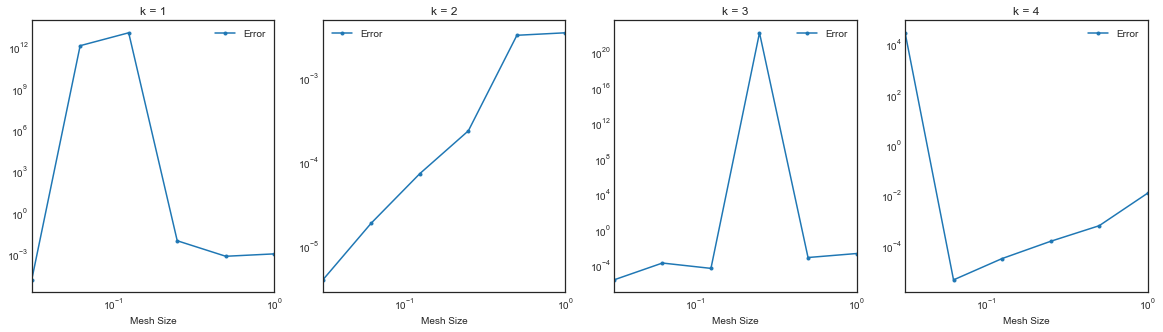

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import pandas as pd
from functools import reduce
from IPython.display import Image, display
import matplotlib.image as mpimg


order_1 = table[table.Order.eq(1.0)]
order_2 = table[table.Order.eq(2.0)]
order_3 = table[table.Order.eq(3.0)]
order_4 = table[table.Order.eq(4.0)]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

order_1.plot(x='Mesh Size', y='Error', ax=ax1, legend=True, title='k = 1', style='.-', loglog=True)
order_2.plot(x='Mesh Size', y='Error', ax=ax2, legend=True, title='k = 2', style='.-', loglog=True)
order_3.plot(x='Mesh Size', y='Error', ax=ax3, legend=True, title='k = 3', style='.-', loglog=True)
order_4.plot(x='Mesh Size', y='Error', ax=ax4, legend=True, title='k = 4', style='.-', loglog=True)



